In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
import math
import pandas as pd
from queue import PriorityQueue
plt.rcParams['font.serif'] = ['Times new Roman']
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['font.size'] = 10.5
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [ ]:
def givemedag(v,e,c):
    if e < v-1:
        print('边太少')
        return None
    #e大小要适量
    D = nx.DiGraph()
    leaves=[]
    while(True):
        nx.generators.directed.gn_graph(v-1,kernel = lambda x :x**c,create_using = D)
        tmp = [x[0] for x in list(D.in_degree()) if x[1] == 0]
        leafnum = len(tmp)
        if D.number_of_edges() + leafnum <= e:
            leaves = tmp.copy()
            break
    #nx.draw(D,with_labels=True)
    
    my_dict = nx.shortest_path_length(nx.reverse_view(D),source=0)
    mylst = list(zip(my_dict.values(), my_dict.keys()))
    #print(my_dict)
    #print(mylst)
    #print(leaves)
    D.add_node(v-1)
    for each in leaves:
        fea = [x[1] for x in mylst if x[0]>my_dict[each]]
        fea.append(v-1)
        D.add_edge(random.choice(fea),each)
    return D.reverse()

In [ ]:
def givemeagent(E, C,var):
    agents = {}
    for e in E:
        ci = np.random.randint(1,C)
        agents[e]=[]
        for i in range(ci):
            bi = -1
            while bi < 0:
                bi = np.random.normal(50,math.sqrt(var))
            ti = -1
            while ti <0:
                ti = np.random.randint(1,100)
            agents[e].append((bi,ti,e,i))
    return agents

In [ ]:
def reweight(dag,agentinfo):
    for e in list(dag.edges):
        dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]

In [ ]:
def allocation2(dag,agentinfo,timelimit):
    #basebid = {}
    relativebid = [(agentinfo[e][i][0]-agentinfo[e][0][0],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3])for e in list(dag.edges)for i in range(1,len(agentinfo[e]))]
    #print('#')
    #print(relativebid)
    #print('#')
    ansdict = {}
    reweight(dag,agentinfo)
    for e in list(dag.edges):
        #dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        ansdict[e] = 0
    #print(relativebid)
    #if nx.dag_longest_path_length(dag) > timelimit:
    #    print('mission impossible')
    #    return -1
    vis = {}
    relativebid.sort(key = lambda x:x[0])
    while relativebid != []:
        if len(vis) == dag.number_of_edges():
            break
        item = relativebid.pop()
        #print('$')
        #print(item)
        if item[2] in vis:
            continue
        tmp = dag.edges[item[2][0],item[2][1]]['weight']
        dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
        if nx.dag_longest_path_length(dag) > timelimit:
            dag.edges[item[2][0],item[2][1]]['weight'] = tmp
            continue
        vis[item[2]] = True
        #print(e)
        #print(item[3])
        ansdict[item[2]] = item[3]
    return ansdict

In [ ]:
def init(dag,agentinfo):
    for e in list(dag.edges):
        agentinfo[e].sort(key=lambda x:x[0],reverse=True)
        agentinfo[e].sort(key = lambda x:x[1]) 
        nowbid = agentinfo[e][0][0]
        tmp = [(agentinfo[e][0][0],agentinfo[e][0][1],agentinfo[e][0][2],0)]
        for i in range(1,len(agentinfo[e])):
            if agentinfo[e][i][0] > nowbid:
                nowbid = agentinfo[e][i][0]
                lens = len(tmp)
                tmp.append((agentinfo[e][i][0],agentinfo[e][i][1],agentinfo[e][i][2],lens))
        agentinfo[e] = tmp

In [ ]:
def graphseq(dag,agentinfo,e,ind,relativebid,timelimit):
    reweight(dag,agentinfo)
    #cong tou qu 
    relativebid.sort(key = lambda x:x[0])
    vis = {}
    if ind > 0:
        sign = False
        addon = agentinfo[e][ind-1][0]-agentinfo[e][0][0]
        
        while relativebid != []:
            item = relativebid.pop()
            if item[2] in vis:
                continue
            if item[2] == e:
                if item[0] <= addon:
                    break
                else:
                    if item[3] == ind:
                        sign=True
                    continue
            tmp = dag.edges[item[2][0],item[2][1]]['weight']
            dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
            if nx.dag_longest_path_length(dag) > timelimit:
                dag.edges[item[2][0],item[2][1]]['weight'] = tmp
                continue
            vis[item[2]] = True
            if sign:
                dag.edges[e[0],e[1]]['weight'] = agentinfo[e][ind][1]
                if nx.dag_longest_path_length(dag) > timelimit:
                    addon = max(addon,item[0])
                    break
                dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        #print(e,1,addon+agentinfo[e][0][0])
        return addon+agentinfo[e][0][0]
    else:
        if len(agentinfo[e]) == 1:
            #print(e,0,0)
            return 0
        graphs=[dag.copy()]
        bids=[0]
        que = PriorityQueue()
        while relativebid != []:
            item = relativebid.pop()
            if item[0] < agentinfo[e][1][0]:
                break
            if item[2] in vis:
                continue
            if item[2] == e:
                pre = len(bids)-1
                if pre > 0:
                    que.put((bids[pre]-item[0],pre,item[3]))
                continue
            tmp = dag.edges[item[2][0],item[2][1]]['weight']
            dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
            if nx.dag_longest_path_length(dag) > timelimit:
                dag.edges[item[2][0],item[2][1]]['weight'] = tmp
                continue
            vis[item[2]] = True
            graphs.append(dag.copy())
            bids.append(item[0])
        acc = 0 #crucial
        addons = -1
        while not que.empty():
            front = que.get()
            if front[1] >= 1:
                delta = bids[front[1]]-(agentinfo[e][front[2]][0] + acc)
                acc = acc + delta
                if acc >= agentinfo[e][0][0]:
                    break
                newdist = max(0,bids[front[1]-1]-bids[front[1]])+ delta
                que.put((newdist,front[1]-1,front[2]))
            prepos = front[1]
            myind = front[2]
            graphs[prepos].edges[e[0],e[1]]['weight'] = agentinfo[e][myind][1]
            if nx.dag_longest_path_length(graphs[prepos]) <= timelimit: 
                addons = bids[prepos+1]-agentinfo[e][myind][0]
                break
            graphs[prepos].edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        if addons == -1:
            #print(e,0,0)
            return 0
        #print(e,0,agentinfo[e][0][0]-addons)
        return agentinfo[e][0][0]-addons

In [ ]:
def payment(dag,agentinfo,timelimit):
    
    relativebid = [(agentinfo[e][i][0]-agentinfo[e][0][0],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3])for e in list(dag.edges)for i in range(1,len(agentinfo[e]))]
    allo = allocation2(dag,agentinfo,timelimit)
    #print(allo)
    ans = 0.0
    for e in list(dag.edges):
        ans = ans + graphseq(dag,agentinfo,e,allo[e],relativebid,timelimit)
    #print(ans)
    return ans

In [ ]:
def checkpay(n,C,kernel,var):
    #n=200
    #C=3
    aoe = givemedag(n,1000000000,kernel)
    assert nx.is_directed_acyclic_graph(aoe)
    #print(aoe.number_of_edges())
    #nx.draw(aoe,with_labels=True)
    es = list(aoe.edges)
    agents = givemeagent(es,C,var)
    init(aoe,agents)
    #print(agents)
    ms = {}
    for e in es:
        ms[e] = (agents[e][0][1],agents[e][len(agents[e])-1][1])
    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][0]
    a = nx.dag_longest_path_length(aoe)

    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][1]
    b = nx.dag_longest_path_length(aoe)
    #print(a,b)
    tl = np.random.randint(a,b+1)
    #payment(aoe,agents,tl)
    return payment(aoe,agents,tl)


In [ ]:
tmp = [checkpay(10,4,1,1)for u in range(20)]
print(np.mean(tmp))

In [ ]:
#为了要第三章线性时间
y = []
x = range(10,1000)
for u in x:
    print(u)
    #t0 = time.perf_counter()
    if u < 505:
        y.append(checkpay(u,4,1,1))
    else:
        y.append(y[494]+checkpay(u-495,4,1,1))
    #y.append(time.perf_counter()-t0)
#y=[checkpay(u,100)for u in x]

plt.plot(x,y)

In [ ]:
k1 = (15000-200)/490
b1 = 200-10*k1
k2 = (500-100)/990
b2 = 100-10*k2
#xtmp = [495 + u for u in x]
#x = list(x)
#x.extend(xtmp)
#ytmp = [y[494]+u for u in y]

#x = range(10,1000) #此处x临时使用
x = x[0:490]

#y1 = [np.random.normal(float(u**2),scale = 1e4)/1e8 for u in x]
y1= []
for u in x:
    tmp = -0.1
    while tmp <= 0:
        tmp = np.random.normal(float(u**2),scale = 1e4)/1e8
    y1.append(tmp*10)
#y.extend(ytmp)

y2 = [(u-b1)/k1*k2+b2 for u in y[0:490]]

y3 = [(u-b1)/k1*k2+b2-90 for u in y[490:980]]

plt.plot(x,y1,label='数据量限制')
plt.plot(x,y2,linestyle = '--',label = '机构限制')
plt.plot(x,y3,linestyle = ':',label = '指标集限制')
plt.ylabel('算法运行时间（秒）')
plt.xlabel('参与者数量（个）')
plt.legend()
plt.savefig('threetimes.pdf')
plt.show()
#threetimes and greedytimes

In [ ]:
#保存中间结果
df = pd.DataFrame({'x':x,'y':y1})
df.to_csv('threetimes_shujuliang.csv',index=False)

df = pd.DataFrame({'x':x,'y':y2})
df.to_csv('threetimes_jigou.csv',index=False)

df = pd.DataFrame({'x':x,'y':y3})
df.to_csv('threetimes_zhibiaoji.csv',index=False)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


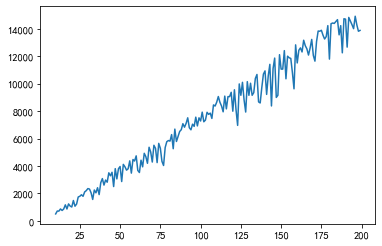

In [42]:
##revenue vs all
y = []
x = range(10,200)
for u in x:
    print(u)
    y.append(checkpay(u,100,1,1))#v,c,kernel,var
#y=[checkpay(u,100)for u in x]

plt.plot(x,y)

In [47]:
ndf = pd.read_csv('revenuevsc.csv')

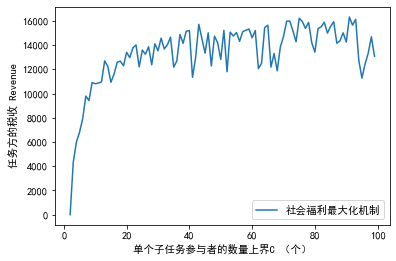

In [52]:
plt.xlabel('单个子任务参与者的数量上界C （个）')
plt.ylabel('任务方的税收 Revenue')

#plt.xlabel('The variance of bids distribution')
#plt.ylabel('Expectation Revenue')

plt.plot('x','y','', data = ndf, label = "社会福利最大化机制")
#plt.plot(x,y2,label="optimal auction")
plt.legend()
plt.savefig('revenuevsc.pdf')
plt.show()

In [45]:
df = pd.DataFrame({'x':x,'y':y})
df.to_csv('revenuevsv.csv',index=False)

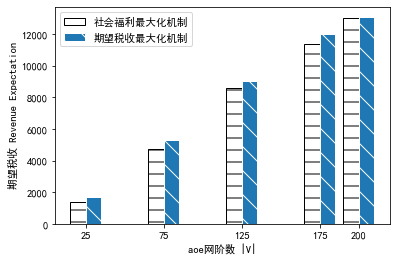

In [57]:
x=[25,75,125,175,200]
y=[1378.312,4737.261,8599.328,11341.959,13031.76]
y2=[1732.41,5302.871,9032.998,12007.221,13076.298]
#plt.bar(x,y)
#plt.bar(x,y2)

#x=np.arange(5)#柱状图在横坐标上的位置
#列出你要显示的数据，数据的列表长度与x长度相同
#y1=[1,3,5,4,2]
#y2=[2,5,3,1,6]

bar_width=10.0#设置柱状图的宽度
#tick_label=['25','75','125','175','南宁']
plt.xlabel('aoe网阶数 |V|')
plt.ylabel('期望税收 Revenue Expectation')
#绘制并列柱状图


plt.bar(x,y,bar_width,label='社会福利最大化机制',hatch='-',fc='w',ec = 'k')
plt.bar([u+bar_width for u in x],y2,bar_width,label='期望税收最大化机制',hatch='\\',fc='tab:blue',ec='w')

plt.legend()#显示图例，即label
plt.xticks([u+bar_width/2 for u in x],x)#显示x坐标轴的标签,即tick_label,调整位置，使其落在两个直方图中间位置
plt.savefig('expswandoptimal.pdf')
plt.show()

In [ ]:

plt.xlabel('$|V|$')
plt.ylabel('The expectation revenue')

#plt.xlabel('The variance of bids distribution')
#plt.ylabel('Expectation Revenue')

plt.plot(x,y,label="SW Maximization")
plt.plot(x,y2,label="optimal auction")
plt.legend()
plt.savefig('expswandoptimal.pdf')
plt.show()

In [ ]:
from matplotlib.patches import  Polygon
x1 = np.linspace(0,1,100)
y1 = np.zeros(100)
x2 = np.linspace(1,2,100)
y2 = np.ones(100)
x3 = np.linspace(2,4,200)
y3 = [2 for u in range(200)]
x4 = np.linspace(4,6,200)
y4 = [3 for u in range(200)]

x5 = [3 for u in range(200)]
y5 = np.linspace(0,2,200)

fig,ax = plt.subplots()

plt.plot(x1,y1,color='k')
plt.plot(x2,y2,color='k')
plt.plot(x3,y3,color='k')
plt.plot(x4,y4,color='k')

plt.plot(x5,y5,color='k',linestyle='dashed')

plt.xticks([0,1,2,3,4],['0','$bid_u$','$bid_v$','$bid_i$','$bid_w$'])
plt.yticks([0,1,2,3])
plt.xlabel('参与者i的标的')
plt.ylabel('参与者i的分配')

yinx = [0,1,1,2,2,4,4,0]
yiny = [0,0,1,1,2,2,3,3]
#plt.fill(yinx,yiny,hatch='.',color='grey',alpha=0.5)
ax.add_patch(Polygon([[0,0],[1,0],[1,1],[2,1],[2,2],[4,2],[4,3],[0,3]], closed=True,
                      fill=False, hatch='.',lw=0.0))
plt.savefig('tanxin_allocation.pdf')
plt.show()

In [ ]:
plt.xlabel('$|V|$')
plt.ylabel('The expectation revenue')

#plt.xlabel('The variance of bids distribution')
#plt.ylabel('Expectation Revenue')

plt.plot(x,y,label="SW Maximization")
plt.plot(x,y2,label="optimal auction")
plt.legend()
plt.savefig('expswandoptimal.pdf')
plt.show()